<a href="https://colab.research.google.com/github/ashutosh96/LearnCompressibleDNN/blob/master/Alex_combined_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # ! pip uninstall -y tensorflow
# # ! pip uninstall -y tf-nightly
# # ! pip install -q -U tf-nightly-gpu
# # ! pip install --pre "tensorflow==1.15.*"
# # ! pip install -q tensorflow-model-optimization

# # Execute this if running data visualization parts of code
# ! pip install scipy==1.1.0
# ! pip install numpy==1.16.1

In [ ]:
# To execute notebook, run this block and import block, and jump directly to 
# Implement AlexNet section. Execute training, pruning and quantization blocks 
# can be skipped if not needed for the experiment. Rest of the blocks should be 
# executed in sequence.

# Revision history:
# 4. Cleaner code(automated different layers training in L1BP)
# 3. Ensemble experiments added. All layers except first 3 layers trained from random initialization.
# 2. L1BP model trained starting from last layer to first. 
# 1. Full AlexNet-Cifar10 implementation, L1BP trained from first to last layer

from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 1.x selected.


# 0. Import Libraries

In [ ]:

from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import layers
from scipy.sparse import csr_matrix
import scipy
from PIL import Image
from tensorflow.contrib.model_pruning.python import pruning
import pickle
import os
import math
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
from time import sleep
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.gradients_impl import _hessian_vector_product as HessVecProd

print(tf.__version__)

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

1.15.2


Using TensorFlow backend.


---
# 1. MNIST Dataset
In the first part of the assignment, we use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. There are 70,000 images, and each image has 784 features. This is because each image is 28×28=784 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The following figure shows a few images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src="https://github.com/ashutosh96/LearnCompressibleDNN/blob/master/figs/1-mnist.png?raw=1" style="width: 300px;"/>

To begin the assignment, first, use `mnist_data.read_data_sets` and download images and labels. It return two lists, called `mnist.test` with 10K images+labels, and `mnist.train` with 60K images+labels.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

mnist = mnist_data.read_data_sets("MNIST_data/", one_hot=True)

mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

55000

---
# 2. Train a multi-layer network



In [ ]:
def model_5l(X,l_sizes):
    XX = tf.reshape(X,[-1,784])

    w = []
    b = []
    l = [XX]
    for i in range(len(l_sizes)-2):
        with tf.variable_scope('Layer_'+str(i+1)) as scope:
            w.append(tf.Variable(tf.random_uniform(shape=[l_sizes[i], 
            l_sizes[i+1]], minval=-0.2, maxval=0.2, dtype=tf.float32,name=("W"+str(i+1)))))
            b.append(tf.Variable(tf.ones([l_sizes[i+1]])*0.1))
            l.append(tf.nn.relu(tf.matmul(l[-1], pruning.apply_mask(w[-1],scope)) + b[-1],name=scope.name))
    i+=1
    with tf.variable_scope('Layer_'+str(i+1)) as scope:
        w.append(tf.Variable(tf.random_uniform(shape=[l_sizes[i], 
        l_sizes[i+1]], minval=-0.2, maxval=0.2, dtype=tf.float32,name=("W"+str(i+1)))))
        b.append(tf.Variable(tf.ones([l_sizes[i+1]])*0.1))
        Y_hat = tf.matmul(l[-1], pruning.apply_mask(w[-1],scope)) + b[-1]
        # store identity op with name so it can be recovered from meta save
        model_output =  tf.identity(Y_hat, name="model_output") 

    l.append(Y_hat)
    return l 

In [ ]:
# m_shapes = [[784,200,100,60,30,10],
#             [784,200,100,70,40,10],
#             [784,200,130,80,50,10],
#             [784,200,150,90,60,10],
#             [784,250,180,120,60,10]]
m_shapes = [[784,200,100,60,30,10],
            [784,200,100,70,40,10],
            [784,200,130,80,50,10],
            [784,200,150,90,60,10],
            [784,250,150,100,50,10]]            
save_names = [('5L2_mnist_'+str(i)+'.ckpt') for i in range(len(m_shapes))]
file_path = 'drive/My Drive/Colab Notebooks Old/ensemble_exp/'

for i in range(len(m_shapes)):
    reset_graph()
    X = tf.placeholder(tf.float32, [None, 784],name='X')
    model = model_5l(X,m_shapes[i])
    Y = tf.placeholder(tf.float32, [None, 10],name='Y')
    saver = tf.train.Saver()

    # remove variable learning rate!!!??
    learning_rate = tf.placeholder(tf.float32, shape=[])
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=model[-1])
    cross_entropy = tf.reduce_mean(cross_entropy)
    # beta = 0.01
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_step = optimizer.minimize(cross_entropy)

    init = tf.global_variables_initializer()
    lr_min = 0.0001
    lr_max = 0.005
    decay_speed = 2000
    n_epochs = 2000
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            # batch_xs, batch_ys = mnist.train.next_batch(200)
            batch_xs = mnist.train.images
            batch_ys = mnist.train.labels
            temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
            sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
            if epoch%200 == 0:
                print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))

        #Save the model
        save_path = saver.save(sess, file_path+save_names[i])
        print("Model saved in path: %s" % save_path)
        #Analyze test performance
        correct_prediction = tf.equal(tf.argmax(model[-1],1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

[2.2187161]
[0.005136001]
[0.00027231552]
[8.518354e-05]
[3.9518956e-05]
[2.1727612e-05]
[1.31828765e-05]
[8.547723e-06]
[5.7872685e-06]
[4.0354034e-06]
Model saved in path: drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_0.ckpt
0.9735
[2.0421455]
[0.0015606845]
[0.00014074583]
[4.7544996e-05]
[2.2481432e-05]
[1.2528443e-05]
[7.663716e-06]
[4.9766563e-06]
[3.3699405e-06]
[2.3546322e-06]
Model saved in path: drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_1.ckpt
0.9745
[2.2451067]
[0.001723097]
[0.0001449233]
[4.940928e-05]
[2.3556666e-05]
[1.3188878e-05]
[8.086501e-06]
[5.2516107e-06]
[3.570353e-06]
[2.508654e-06]
Model saved in path: drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_2.ckpt
0.9735
[2.3762264]
[0.0019322701]
[0.0001184532]
[3.8224414e-05]
[1.7742452e-05]
[9.862373e-06]
[6.008641e-06]
[3.8900594e-06]
[2.636658e-06]
[1.8376429e-06]
Model saved in path: drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_3.ckpt
0.9728
[2.2277255]
[0.000877

### Pruning the trained 5 layer model

In [ ]:
# m_shapes = [[784,200,100,60,30,10],
#             [784,200,100,70,40,10],
#             [784,200,130,80,50,10],
#             [784,200,150,90,60,10],
#             [784,250,180,120,60,10]]
m_shapes = [[784,200,100,60,30,10],
            [784,200,100,70,40,10],
            [784,200,130,80,50,10],
            [784,200,150,90,60,10],
            [784,250,150,100,50,10]]         
file_path = 'drive/My Drive/Colab Notebooks Old/ensemble_exp/'            
load_names = [('5L2_mnist_'+str(i)+'.ckpt') for i in range(len(m_shapes))]
save_names = [('5L2_mnist'+str(i)+'_pruned90.ckpt') for i in range(len(m_shapes))]
target_sparsity = 0.90

for i in range(len(m_shapes)):
    reset_graph()
    # Define model
    X = tf.placeholder(tf.float32, [None, 784],name='X')
    model = model_5l(X,m_shapes[i])
    Y = tf.placeholder(tf.float32, [None, 10],name='Y')
    saver = tf.train.Saver()

    # Reset global step op
    global_step = tf.train.get_or_create_global_step()
    reset_global_step_op = tf.assign(global_step, 0)

    # Define pruning hparams
    pruning_hparams = pruning.get_pruning_hparams()
    pruning_hparams.begin_pruning_step = 0
    pruning_hparams.end_pruning_step = 500
    pruning_hparams.pruning_frequency = 1
    pruning_hparams.sparsity_function_end_step = 500
    pruning_hparams.target_sparsity = target_sparsity
    print("Pruning Hyperparameters:", pruning_hparams)

    # Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
    p = pruning.Pruning(pruning_hparams, global_step=global_step)
    prune_op = p.conditional_mask_update_op()

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=model[-1])
    cross_entropy = tf.reduce_mean(cross_entropy)
    train_step = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(cross_entropy, global_step=global_step)
    
    init = tf.global_variables_initializer()
    n_epochs = 1000

    with tf.Session() as sess:

        sess.run(init)
        # Restore original trained weights
        saver.restore(sess, file_path+load_names[i])

        correct_prediction = tf.equal(tf.argmax(model[-1],1), tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy of original model: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
        sess.run(reset_global_step_op)
        print("Starting with retraining")   
        for epoch in range(n_epochs):
            # batch_xs, batch_ys = mnist.train.next_batch(200)
            batch_xs = mnist.train.images
            batch_ys = mnist.train.labels
            sess.run(prune_op)
            sess.run(train_step, {X:batch_xs, Y:batch_ys})
            if epoch%200 == 0:
                print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
                print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

        #Save trained model
        save_path = saver.save(sess, file_path+save_names[i])
        print("Model saved in path: %s" % save_path)
        print("Accuracy after retraining \n",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))


Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=500,weight_sparsity_map=[''],block_dims_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.9,sparsity_function_begin_step=0,sparsity_function_end_step=500,sparsity_function_exponent=3.0,use_tpu=False
INFO:tensorflow:Updating masks.
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_0.ckpt
Accuracy of original model:  0.9735
Starting with retraining
[0.00028994755]
Weight sparsities: [0.0, 0.0, 0.0, 0.0, 0.0]
[0.08360541]
Weight sparsities: [0.7055995, 0.70559996, 0.70566666, 0.70555556, 0.7066667]
[0.21725371]
Weight sparsities: [0.89279974, 0.8928, 0.89283335, 0.8927778, 0.8933334]
[0.06509825]
Weight sparsities: [0.9, 0.9, 0.9, 0.90000004, 0.90000004]
[0.044349495]
Weight sparsities: [0.9, 0.9, 0.9, 0.90000004, 0.90000004]
Model saved in path: drive/My D

### Ensemble experiment

In [ ]:
# Variable to store accuracies for plotting curves
acc = []

In [ ]:
from keras.utils import to_categorical

# all model names in list
n_models = 5
file_path = 'drive/My Drive/Colab Notebooks Old/ensemble_exp/'        
# model_names = [('5L2_mnist'+str(i)+'_pruned98.ckpt') for i in range(n_models)]
# meta_names = [('5L2_mnist'+str(i)+'_pruned98.ckpt.meta') for i in range(n_models)]
model_names = [('5L2_mnist_'+str(i)+'.ckpt') for i in range(n_models)]
meta_names = [('5L2_mnist_'+str(i)+'.ckpt.meta') for i in range(n_models)]

# One hot encoding of model predictions to implement majority vote
def one_hot_trans(arr,n_classes=10):
        encoded = [[0 for i in range(n_classes)] for j in range(arr.shape[0])]
        for i in range(arr.shape[0]):
            encoded[i][arr[i]] = 1
        return encoded

pred = []       # list of output of individual models
for i in range(len(model_names)):
    reset_graph()
    with tf.Session() as sess:
        # Load graph and weights           
        new_saver = tf.train.import_meta_graph(file_path+meta_names[i])
        new_saver.restore(sess, file_path+model_names[i])

        # Get required ops->tensors->python variables
        graph = tf.get_default_graph()
        tensors = graph.get_operations()
        req_tensors = [v for v in tensors if (str(v.name) == 'Layer_5/model_output' or 
                                             str(v.name) == 'Y') or 
                                             str(v.name) == 'X'] 
        X = req_tensors[0].outputs[0]
        model_pred = req_tensors[1].outputs[0]
        Y = req_tensors[2].outputs[0]   

        # # Make and save model predictions
        # correct_prediction = tf.equal(tf.argmax(model_pred,1), tf.argmax(Y,1))
        # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # print("Model accuracy: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

        # # Run quantization ops
        # for i in range(16):
        #     sess.run(quant_ops[i])
        pred.append(sess.run(model_pred, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

# Consensus variable using sum of soft predictions
def soft_cons(pred):
    cons = pred[0]      
    for k in range(len(pred)-1):
        for i in range(len(pred[k+1])):
            for j in range(len(pred[k][i])):
                cons[i][j] = cons[i][j] + pred[k+1][i][j]
    return cons

# Consensus variable using majority vote
def vote_cons(pred):
    cons = one_hot_trans(np.argmax(pred[0],axis=1))
    for k in range(len(pred)-1):
        model_pred = one_hot_trans(np.argmax(pred[k+1],axis=1))
        for i in range(len(pred[k+1])):
            for j in range(len(pred[k][i])):
                cons[i][j] = cons[i][j] + model_pred[i][j]
    return cons

with tf.Session() as sess:
    for i in range(len(pred)):
        indiv_pred = tf.equal(tf.argmax(pred[i],1), tf.argmax(Y,1))
        indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
        print("Model accuracy: ",sess.run(indiv_accuracy, feed_dict={Y: mnist.test.labels}))
    
    acc.append([])      # Store accuracies for plotting curves
    print('Models   |Consensus A    |Consensus B')
    for i in range(len(pred)):
        cons_1 = soft_cons(pred[:i+1])
        cons_2 = vote_cons(pred[:i+1])
        cons_pred1 = tf.equal(tf.argmax(cons_1, 1), tf.argmax(Y, 1)) 
        cons_pred2 = tf.equal(tf.argmax(cons_2, 1), tf.argmax(Y, 1)) 
        cons_accuracy1 = tf.reduce_mean(tf.cast(cons_pred1, tf.float32))
        cons_accuracy2 = tf.reduce_mean(tf.cast(cons_pred2, tf.float32))
        a1 = sess.run(cons_accuracy1, feed_dict={Y:mnist.test.labels})
        a2 = sess.run(cons_accuracy2, feed_dict={Y:mnist.test.labels})
        print(str(i+1)+'        '+str(a1)+'         '+str(a2))
        acc[-1].append(a1)

    conf_matr = tf.confusion_matrix(tf.argmax(Y,1),tf.argmax(soft_cons(pred),1))
    print('Confusion matrix: \n',sess.run(conf_matr, feed_dict={Y:mnist.test.labels}))
     

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_0.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_1.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_2.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_3.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/5L2_mnist_4.ckpt
Model accuracy:  0.9735
Model accuracy:  0.9745
Model accuracy:  0.9735
Model accuracy:  0.9728
Model accuracy:  0.9745
Models   |Consensus A    |Consensus B
1        0.9735         0.9735
2        0.9785         0.9761
3        0.9803         0.9803
4        0.98         0.9793
5        0.9803         0.9804
Confusion matrix: 
 [[ 971    0    0    1    0    1    1    1    4    1]
 [   0 1125    3    1    0    1    2    1    2    0]
 [   4    2 1010    3    1  

#### Plot ensemble results

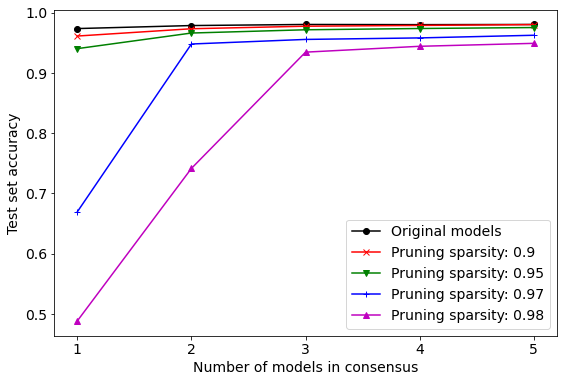

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
# print(acc)

acc1 = [[0.9611, 0.9732, 0.9774, 0.9787, 0.9801], [0.9402, 0.9661, 0.9715, 0.9736, 0.9752], [0.6695, 0.9479, 0.9555, 0.958, 0.9624], [0.4886, 0.7416, 0.9344, 0.9441, 0.949]]
acc1.insert(0,acc[0])
acc = acc1

prnt_sparsities = [0.90,0.95,0.97,0.98]
labels = [('Pruning sparsity: '+str(i)) for i in prnt_sparsities]
labels.insert(0,'Original models')

fig = plt.figure(1,figsize=(9,6))
plt.plot([1,2,3,4,5],acc[0],'k',label=labels[0],marker="o")
plt.plot([1,2,3,4,5],acc[1],'r-',label=labels[1],marker="x")
plt.plot([1,2,3,4,5],acc[2],'g-',label=labels[2],marker="v")
plt.plot([1,2,3,4,5],acc[3],'b-',label=labels[3],marker="+")
plt.plot([1,2,3,4,5],acc[4],'m-',label=labels[4],marker="^")

plt.xticks([1,2,3,4,5])
# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.734,0.7269,0.6999,0.64,0.5001,0.4502], label='Regularized model',marker='x')
plt.xlabel('Number of models in consensus')
plt.ylabel('Test set accuracy')
plt.legend()
# plt.title('Inference accuracy vs number of models in consensus')
fig.savefig('mnist_ensemble.pdf')

---
# 10. Implement AlexNet
 **AlexNet** [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

```
#--------------------
# fc8
# (4096, 1000) # weights
# (1000,) # bias
#--------------------
# fc7
# (4096, 4096) # weights
# (4096,) # bias
#--------------------
# fc6
# (9216, 4096) # weights
# (4096,) # bias
#--------------------
# conv5
# (3, 3, 192, 256) # weights
# (256,) # bias
#--------------------
# conv4
# (3, 3, 192, 384) # weights
# (384,) # bias
#--------------------
# conv3
# (3, 3, 256, 384) # weights
# (384,) # bias
#--------------------
# conv2
# (5, 5, 48, 256) # weights
# (256,) # bias
#--------------------
# conv1
# (11, 11, 3, 96) # weights
# (96,) # bias
```


### Load CIFAR-10 dataset

In [ ]:
# ! tar -xvf drive/My\ Drive/Colab\ Notebooks/cifar-10-python.tar
# ! mkdir drive/My\ Drive/Colab\ Notebooks/cifar-10-batches-py
# ! mv  -v cifar-10-batches-py/* drive/My\ Drive/Colab\ Notebooks/cifar-10-batches-py/

In [ ]:
# Decide image size. (32 or 70)
img_size = 70

# Unpickle particular batch file into a dictionary
def __extract_file__(fname):
    with open(fname, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

def __unflatten_image__(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    ##********##
    img = scipy.misc.imresize(img,size=(img_size,img_size),interp='bicubic')
    ##********##
    return img

# Extract only data and labels and then reshape for use  
def __extract_reshape_file__(fname):
    res = []
    d = __extract_file__(fname)
    images = d[b"data"]
    labels = d[b"labels"]
    for image, label in zip(images, labels):
        res.append((__unflatten_image__(image), label))
    return res
  
# Load data from all batches into a single variable 
def get_images_from(dir):
    files = [f for f in os.listdir(dir) if f.startswith("data_batch")]
    res = []
    for f in files:
        res = res + __extract_reshape_file__(os.path.join(dir, f))
    return res
    

class Cifar(object):

    def __init__(self, dir="data/cifar-10-batches-py/", batch_size=1):
        self.__res__ = get_images_from(dir)
        self.batch_size = batch_size
        self.batches = []
        self.__batch_num__ = 0
        # Divide the data into batches
        for i in range(math.ceil(len(self.__res__)/batch_size)):
            self.batches.append(self.__res__[i*batch_size:(i+1)*batch_size])
        self.test_set = __extract_reshape_file__(os.path.join(dir, "test_batch"))
        
    def batch(self, num):
        return self.batches[num]

    def next_batch(self):
        if self.__batch_num__ <= len(self.batches):
            res = self.batches[self.__batch_num__]
            self.__batch_num__ = self.__batch_num__ + 1
        else:
            res = []

        return res

    def reset_batch(self):
        self.__batch_num__ = 0

# Processing the batches to form input and output matrix        
def one_hot(num, dim=1000):
    vec = np.zeros(dim)
    vec[num] = 1
    return vec


def transform_to_input_output(input_output, dim=1000):
    input_vals = []
    output_vals = []
    for input_val, output_val in input_output:
        input_vals.append(input_val)
        output_vals.append(output_val)

    return np.array(input_vals), np.array([one_hot(out, dim=dim)
         for out in output_vals], dtype="uint8")

### Define original model

Removed LRN from model as double derivative of LRN not available in tensorflow.

In [ ]:
""" build the AlexNet model
* Use Alexnet(), not Alexnet_small
* Function returns output of all important layers to help construct two networks 
with the same architecture later
* Removed LRN in final implementation as its double derivative is not natively 
supported by tensorflow. 

100_noLRN3,256,128,p=0.9,b=128 (74.5%) 120 epochs last_2layer_dropout
100_noLRN4,256,192,p=0.6,b=128 (72.5%) 60 epochs     l6_l7_dropout 
100_noLRN5,256,256,p=0.7,b=128 (60.5%) 100 epochs last_2layer_dropout  
100_noLRN6,256,256,p=0.6,b=128 (71.3%) 50 epochs   l6_l7_dropout  
100_noLRN7,384,256,256,p=0.5,b=128 (71.3) 60 epochs l6_l7_dropout  
100_noLRN8,384,384,256,p=0.5,b=128 (73%) 60 epochs l6_l7_dropout  
"""
from tensorflow import layers

# Used for convolving split layers with split kernel, with 2 gpu in parallel
def conv2d_split(X, filters, kernel_size, strides, name, activation):
    input_channels = int(X.get_shape()[-1])
    with tf.variable_scope(name):
        # Fetch kernel variable in name scope with given shape
        weights = tf.get_variable('kernel', initializer = random_values([kernel_size, kernel_size, int(input_channels/2), filters]))
        # Fetch bias variable in name scope with given shape
        biases = tf.get_variable('bias', initializer =tf.ones(shape=[filters], dtype=tf.float32))
    
    conv = lambda x, w: tf.nn.conv2d(x, w, strides = [1, strides, strides, 1], padding="SAME")
    
    input_groups = tf.split(axis = 3, num_or_size_splits=2, value=X)
    weight_groups = tf.split(axis = 3, num_or_size_splits=2, value=pruning.apply_mask(weights,name))
    output_groups = [conv(x, w) for x,w in zip(input_groups, weight_groups)]

    output = tf.concat(axis = 3, values = output_groups) + biases
    
    return activation(output)
    
random_mean = 0
random_stddev = 0.01
def random_values(shape):
    return tf.random_normal(shape=shape, mean=random_mean, stddev=random_stddev, dtype=tf.float32)

def AlexNet(X,pkeep = 0.5):
    print(np.shape(X))
    with tf.variable_scope('conv1'):
        w = tf.get_variable('kernel', initializer = random_values([11,11,3,96]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [96], dtype=tf.float32))
    # Choose stride from 1 or 4 depending on CIFAR or Imagenet    
    c1 = tf.nn.conv2d(X, pruning.apply_mask(w,'conv1'), strides = [1, 4, 4, 1], padding="SAME")
    c1 = c1 + b
    c1 = tf.nn.relu(c1)
    print(np.shape(c1))
    # c1 = layers.conv2d(X, filters=96, kernel_size=11, strides=4, padding="SAME", activation='relu', name='conv1')
    # lrn1 = tf.nn.lrn(c1, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m1 = layers.max_pooling2d(c1, pool_size=3, strides=2, padding="VALID")
        
    c2 = conv2d_split(m1, filters=256, kernel_size=5, strides=1, name="conv2", activation=tf.nn.relu)
    print(np.shape(c2))
    # lrn2 = tf.nn.lrn(c2, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m2 = layers.max_pooling2d(c2, pool_size=3, strides=2, padding="VALID")
    
    with tf.variable_scope('conv3'):
        w =  tf.get_variable('kernel', initializer = random_values([3,3,256,384]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [384]), dtype=tf.float32)
    c3 = tf.nn.conv2d(m2, pruning.apply_mask(w,'conv3'), strides = [1, 1, 1, 1], padding="SAME")
    c3 = c3 + b
    c3 = tf.nn.relu(c3)
    # c3 = layers.conv2d(m2, filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu', name='conv3')
    print(np.shape(c3))
    c4 = conv2d_split(c3, filters=384, kernel_size=3, strides=1, name="conv4", activation=tf.nn.relu)
    print(np.shape(c4))
    
    # c5 = conv2d_split(c4, filters=256, kernel_size=3, strides=1, activation=tf.nn.relu, name='conv5')
    c5 = conv2d_split(c4, filters=256, kernel_size=3, strides=1, activation=tf.nn.relu, name='conv5')
    print(np.shape(c5))
    m5 = layers.max_pooling2d(c5, pool_size=3, strides=2, padding="VALID")
    m5 = layers.flatten(m5)
    
    with tf.variable_scope('fc6'):
        # w =  tf.get_variable('kernel', initializer = random_values([256,256]))
        w =  tf.get_variable('kernel', initializer = random_values([256,256]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [256]), dtype=tf.float32)
    f6 = tf.nn.relu(tf.matmul(m5, pruning.apply_mask(w,'fc6')) + b)
    print(np.shape(f6))
    # f6 = tf.nn.dropout(f6, keep_prob=pkeep, name='f6_dropout')
    # f6 = layers.dense(m5, 4096, activation='relu', name="fc6")

    with tf.variable_scope('fc7'):
        # w =  tf.get_variable('kernel', initializer = random_values([256,128]))
        # b = tf.get_variable('bias',initializer =tf.ones(shape = [128]), dtype=tf.float32)
        w =  tf.get_variable('kernel', initializer = random_values([256,128]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [128]), dtype=tf.float32)
    f7 = tf.nn.relu(tf.matmul(f6, pruning.apply_mask(w,'fc7')) + b)
    print(np.shape(f7))
    # f7 = layers.dense(f6, 4096, activation='relu', name="fc7")
    f7 = tf.nn.dropout(f7, keep_prob=pkeep, name='f7_dropout')
    # Set the number of output classes
    with tf.variable_scope('fc8'):
        # w = tf.get_variable('kernel', initializer = random_values([128,10]))
        w = tf.get_variable('kernel', initializer = random_values([128,10]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [10]), dtype=tf.float32)
    f8 = (tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
    print(np.shape(f8))
    #  f8 = tf.nn.softmax(tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
    #  f8 = layers.dense(f7, 1000, activation='softmax', name="fc8")
    f8 = tf.nn.dropout(f8, keep_prob=pkeep, name='f8_dropout')
    
    return [c1,c2,c3,c4,c5,f6,f7,f8]


def AlexNet_small(X):
    with tf.variable_scope('conv1'):
        w = tf.get_variable('kernel', [3,3,3,64])
        b = tf.get_variable('bias',shape = [64])
    # Choose stride from 1 or 4 depending on CIFAR or Imagenet    
    c1 = tf.nn.conv2d(X, pruning.apply_mask(w,'conv1'), strides = [1, 1, 1, 1], padding="SAME")
    c1 = c1 + b
    c1 = tf.nn.relu(c1)
    print(np.shape(c1))
    # c1 = layers.conv2d(X, filters=96, kernel_size=11, strides=4, padding="SAME", activation='relu', name='conv1')
    lrn1 = tf.nn.lrn(c1, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m1 = layers.max_pooling2d(lrn1, pool_size=2, strides=1, padding="VALID")
        
    c2 = conv2d_split(m1, filters=192, kernel_size=3, strides=2, name="conv2", activation=tf.nn.relu)
    print(np.shape(c2))
    lrn2 = tf.nn.lrn(c2, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m2 = layers.max_pooling2d(lrn2, pool_size=2, strides=1, padding="VALID")
    
    with tf.variable_scope('conv3'):
        w = tf.get_variable('kernel', [3,3,192,384])
        b = tf.get_variable('bias',shape = [384])
    c3 = tf.nn.conv2d(m2, pruning.apply_mask(w,'conv3'), strides = [1, 2, 2, 1], padding="SAME")
    c3 = c3 + b
    c3 = tf.nn.relu(c3)
    # c3 = layers.conv2d(m2, filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu', name='conv3')
    print(np.shape(c3))
    c4 = conv2d_split(c3, filters=256, kernel_size=3, strides=1, name="conv4", activation=tf.nn.relu)
    print(np.shape(c4))
    
    c5 = conv2d_split(c4, filters=256, kernel_size=3, strides=1, activation=tf.nn.relu, name='conv5')
    print(np.shape(c5))
    m5 = layers.max_pooling2d(c5, pool_size=3, strides=2, padding="VALID")
    m5 = layers.flatten(m5)
    print(np.shape(m5))
    # Choose dim from [2304,512] or [9216,4096] depending on CIFAR or Imagenet  
    with tf.variable_scope('fc6'):
        w = tf.get_variable('kernel',[2304,1024])
        b = tf.get_variable('bias',shape=[1024])
    f6 = tf.nn.relu(tf.matmul(m5, pruning.apply_mask(w,'fc6')) + b)
    # f6 = layers.dense(m5, 4096, activation='relu', name="fc6")

    # Choose dim from [512,512] or [4096,4096] depending on CIFAR or Imagenet 
    with tf.variable_scope('fc7'):
        w = tf.get_variable('kernel',[1024,256])
        b = tf.get_variable('bias',shape=[256])
    f7 = tf.nn.relu(tf.matmul(f6, pruning.apply_mask(w,'fc7')) + b)
    # f7 = layers.dense(f6, 4096, activation='relu', name="fc7")

    # Set the number of output classes
    with tf.variable_scope('fc8'):
        w = tf.get_variable('kernel',[256,10])
        b = tf.get_variable('bias',shape=[10])
    f8 = (tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
    # f8 = tf.nn.softmax(tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
    # f8 = layers.dense(f7, 1000, activation='softmax', name="fc8")

    return f8

# load inital weights and biases to the model
def load_initial_weights(session):
    # load the weights into memory
    weights_dict = np.load('drive/My Drive/Colab Notebooks/AlexNet_trained/bvlc_alexnet.npy', encoding='bytes').item()
    # Create a dictionary with all global variables available
    var_dict = dict((v.name, v) for v in tf.global_variables())
    #print(v for v in var_dict.keys())
    # loop over all layer names stored in the weights dict
    for layer in weights_dict:
        with tf.variable_scope(layer, reuse=True):
            # loop over list of weights/biases and assign them to their corresponding tf variable
            for wb in weights_dict[layer]:
                # biases
                if len(wb.shape) == 1:
                    bias = var_dict[layer+'/bias:0']
                    session.run(bias.assign(wb))
                # weights
                else:
                    weight =  var_dict[layer+'/kernel:0']
                    session.run(weight.assign(wb))
                    
# load the ImageNet ILSVRC dataset for retraining


#### Train AlexNet on Cifar-10

In [ ]:
file_path = 'drive/My Drive/Colab Notebooks Old/'
n_out = 10 # number of output classes
batch_size = 128

#### Load Data A
# data = Cifar(file_path+'cifar-10-batches-py/',batch_size)
# print('Size of dataset:',len(data.__res__))
# x_test, y_test = transform_to_input_output(data.test_set, dim=n_out)
# ### Do this if using augmented data ###
# x_train = np.array([row[0] for row in data.__res__])
# y_train = np.array(np.reshape([row[1] for row in data.__res__],(-1,1)))
# # Augment the dataset
# print(np.shape(x_train),np.shape(y_train))
# datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, 
#                              height_shift_range=0.1, horizontal_flip=True)
# datagen.fit(x_train)
# gen = datagen.flow(x_train,y_train,batch_size=batch_size)

#### Load Data B
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_, x_test_, y_train_, y_test_= [],[],[],[]
for i in range(len(x_train)):
    # x_train_.append(scipy.misc.imresize(x_train[i],size=(img_size,img_size),interp='bicubic'))
    x_train_.append(np.array(Image.fromarray(x_train[i]).resize((img_size,img_size))))
for i in range(len(x_test)):
    # x_test_.append(scipy.misc.imresize(x_test[i],size=(img_size,img_size),interp='bicubic')) 
    x_test_.append(np.array(Image.fromarray(x_test[i]).resize((img_size,img_size))))
x_train = np.array(x_train_)
x_test = np.array(x_test_)
x_test, y_test = transform_to_input_output(zip(x_test,y_test), dim=n_out)
datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, 
                             height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)
gen = datagen.flow(x_train,y_train,batch_size=batch_size)

n_epochs = 60

# Reset graph and define model
reset_graph()

X = tf.placeholder(shape=[None, img_size, img_size, 3], dtype=tf.float32, name='X')
y = tf.placeholder(tf.float32, [None, 10])
model = AlexNet(X,0.9)
alex = model[7]
# Define tensor name for model output so it can be restored
model_output =  tf.identity(alex, name="model_output")

learning_rate = 5e-3    
momentum = 0.9
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

170500096/170498071 [==============================] - 2s 0us/step
(?, 70, 70, 3)
(?, 18, 18, 96)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
Instructions for updating:
Use keras.layers.flatten instead.
(?, 256)
(?, 128)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 10)


##### Execute training( Skip if trained )

In [ ]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=momentum).minimize(cost)
# load_path = file_path + "AlexNet_Cifar_trained100_noLRN_5.ckpt"
save_name = "AlexNet_Cifar_trained100_noLRN_4.ckpt"
saver = tf.train.Saver() 

with tf.Session() as sess:

    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    init = tf.global_variables_initializer()
    sess.run(init)
    # saver.restore(sess,load_path)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            batches+=1
            if batches >= len(x_train)/batch_size:
                break
            
        acc = sess.run(accuracy, feed_dict={X: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={X: batch_x, y: batch_y})                       
        print("epoch {} Acc: {} Loss: {}".format(epoch, acc, loss))
    
        test_acc = sess.run(accuracy, feed_dict={X: x_test, y: y_test})    
        print("Test set accuracy: {}".format(test_acc))

    save_path = saver.save(sess, file_path+save_name)
    print("Model saved in path: %s" % save_path)
    
#####
# 100_1:original alexnet, p=0.7, b=128 (64%)
# 100_2:128,128, p=0.8, b=128 (64%)
# 100_3:256,128, p=0.8, b=128 (65%)
# 100_4:4096, 4096, p=0.8, b=128 (68%) augmented data
# 100_x:4096, 1024, p=0.6, b=128 (53%)
# 100_5:256,128, p=0.7, b=256 (56%)
# 100_6:256,128, p=0.75, b=64 (62.3%)
# 100_7:256,128, p=0.9, b=64 (70.4%)
# 100_8:256,128, p=0.9, b=128 (71.5%) augmented data, can train more
# 100_9:256,128, p=0.9, b=128 (73%) augmented data, can train more
# 100_noLRN1,128,p=0.9, b=128 (71.5%) augmented data, no LRN layers
# 100_noLRN3,128,p=0.9, b=128 (74.5%) augmented data, no LRN layers, 120 epochs

# 100_noLRN6,256,256,p=0.7, (60.5%) 100 epochs
# 100_noLRN7,

ValueError: ignored

#### Prune original model

In [ ]:
# To load and resave old checkpoints with added name of model output op
# so model can be restored using the meta file.

# # reset_graph()
# model_path = file_path+"ensemble_exp/AlexNet_noLRN3_pruned95.ckpt"
# # save_path = file_path+"ensemble_exp/AlexNet_noLRN8_pruned95.ckpt"
# # meta_name = file_path+"ensemble_exp/AlexNet_noLRN5_pruned95.ckpt.meta"

# saver = tf.train.Saver()
# # new_saver = tf.train.import_meta_graph(meta_name)

# with tf.Session() as sess:
#     saver.restore(sess, model_path)
#     saver.save(sess, model_path)
#     # new_saver.restore(sess, save_path)
#     for op in tf.get_default_graph().get_operations():
#         print(str(op.name))


In [ ]:
saver = tf.train.Saver()

model_path = file_path+"AlexNet_Cifar_trained100_noLRN_3.ckpt"
save_name = "ensemble_exp/AlexNet_noLRN3_pruned97.ckpt"
target_sparsity = 0.97
# ensemble_seed = 1
# save_name = "AlexNet_noLRN3_pruned_x.ckpt"

rand_prune = 0.3 # Fraction of l7 and l8 weights to be deleted randomly b4 pruning
n_epochs = 100

# Define reduced dataset
fraction = 10       # Training is done only on 1/fraction of the dataset 
print_freq = 10     # How often to print losses during training
dataset_size = int(50000/fraction)
batch_size = 1250

idx = random.sample(range(50000), dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# Get variables for random pruning of layer 7 and 8
# np.random.seed(ensemble_seed)
# with tf.variable_scope('fc7'):
#     tf.get_variable_scope().reuse_variables() 
#     w7 =  tf.get_variable('kernel', initializer = random_values([256,128]))
#     mask1 = tf.cast(np.random.choice(a=[False, True], size=np.shape(w7), 
#                                      p=[rand_prune, 1-rand_prune]),w7.dtype)      
#     b7 = tf.get_variable('bias',initializer =tf.ones(shape = [128]), dtype=tf.float32)
#     mask2 = tf.cast(np.random.choice(a=[False, True], size=np.shape(b7), 
#                                      p=[rand_prune, 1-rand_prune]),b7.dtype)    
    
# with tf.variable_scope('fc8'):
#     tf.get_variable_scope().reuse_variables() 
#     w8 = tf.get_variable('kernel', initializer = random_values([128,10]))
#     mask3 = tf.cast(np.random.choice(a=[False, True], size=np.shape(w8), 
#                                      p=[rand_prune, 1-rand_prune]),w8.dtype)       
#     b8 = tf.get_variable('bias',initializer =tf.ones(shape = [10]), dtype=tf.float32)
#     mask4 = tf.cast(np.random.choice(a=[False, True], size=np.shape(b8), 
#                                      p=[rand_prune, 1-rand_prune]),b8.dtype)  

# Pruning code begins
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 100  # dataset_size/batch_size #steps/epoch
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 100
pruning_hparams.target_sparsity = target_sparsity

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

learning_rate = 5e-3    
momentum = 0.9
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=momentum).minimize(cost, global_step =global_step)

with tf.Session() as sess:
#     X = tf.placeholder(shape=[None, 70, 70, 3], dtype=tf.float32, name='X')
#     alex = AlexNet(X)
    init = tf.global_variables_initializer() # needs to be defined after model is generated
    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, model_path)
    
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Accuracy of original model: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))

    # Randomly delete 10% weights in layer 7 and layer 8
    # sess.run(tf.assign(w7, w7*mask1)) 
    # sess.run(tf.assign(w8, w8*mask3))

    print("Accuracy after random pruning: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    print("Starting with retraining")
    

#     gen = datagen.flow(x_train,y_train,batch_size=batch_size)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run(prune_op)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        if epoch%print_freq == 0:
                print(sess.run([cost],{X:batch_x, y:batch_y}))
                print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = saver.save(sess, file_path+save_name)
    print("Model saved in path: %s" % save_path)

    print("Accuracy after gradual pruning and retraining",sess.run(accuracy, feed_dict={X: x_test, y: y_test}))
    
    """ Results:
    Filenames: "AlexNet_pruned_<75>.ckpt" orig acc: 73 
    sparsity: 0.75 pruning_period: 100 epochs: 130 accuracy: 73
    sparsity: 0.8 pruning_period: 100 epochs: 150 accuracy: 71.84
    sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.72
    sparsity: 0.9 pruning_period: 100 epochs: 130 accuracy: 63.69
    sparsity: 0.95 pruning_period: 100 epochs: 130 accuracy: 48.78

    Filenames: "AlexNet_noLRN_pruned_<75>.ckpt" orig acc: 71.4
    sparsity: 0.75 pruning_period: 100 epochs: 130 accuracy:70.88 
    sparsity: 0.75_ pruning_period: 50 epochs: 100 accuracy:69.42
    sparsity: 0.75__ pruning_period: 100, pruning_freq:5 epochs: 130 accuracy: 70.85
    sparsity: 0.80 pruning_period:100 epochs: 130 accuracy: 69.58
    sparsity: 0.85 pruning_period:100 epochs: 130 accuracy: 67.49
    sparsity: 0.90 pruning_period:100 epochs: 130 accuracy: 61.87
    """
  

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=100,weight_sparsity_map=[''],block_dims_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.97,sparsity_function_begin_step=0,sparsity_function_end_step=100,sparsity_function_exponent=3.0,use_tpu=False
INFO:tensorflow:Updating masks.
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/AlexNet_Cifar_trained100_noLRN_3.ckpt
Accuracy of original model:  0.7459
Accuracy after random pruning:  0.7453
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Starting with retraining
[0.47438908]
Weight sparsities: [0.08471074, 0.08470704, 0.08470663, 0.08470775, 0.08470775, 0.08470154, 0.0847168, 0.084375]
[1.1512614]
Weight sparsities: [0.79037535, 0.79036134, 0.79036236, 0.7903631, 0.79036236, 0.7903595, 0.79037476, 0.79062504]
[2.0854561]
Weight sparsities: [0.9652204, 0.96523

#### Quantize original model

In [ ]:
# model_path = file_path+"AlexNet_noLRN_pruned_75.ckpt"
model_path = file_path+ "AlexNet_Cifar_trained100_noLRN_1.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
#                            "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})

# First get old variable and then initialize new variables with old variables
with tf.variable_scope('conv1'):
    tf.get_variable_scope().reuse_variables()        
    w1_ = tf.get_variable('kernel', [11, 11, 3, 96])
    b1_ = tf.get_variable('bias',shape = [96])
with tf.variable_scope('conv2'):
    tf.get_variable_scope().reuse_variables()
    w2_ = tf.get_variable('kernel', [5, 5, 48, 256])
    b2_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('conv3'):
    tf.get_variable_scope().reuse_variables()
    w3_ = tf.get_variable('kernel', [3, 3, 256, 384])
    b3_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('conv4'):
    tf.get_variable_scope().reuse_variables()
    w4_ = tf.get_variable('kernel', [3, 3, 192, 384])
    b4_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('conv5'):
    tf.get_variable_scope().reuse_variables()
    w5_ = tf.get_variable('kernel', [3, 3, 192, 256])
    b5_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('fc6'):
    tf.get_variable_scope().reuse_variables()
    w6_ = tf.get_variable('kernel', [256, 256])
    b6_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('fc7'):
    tf.get_variable_scope().reuse_variables()
    w7_ = tf.get_variable('kernel', [256, 128])
    b7_ = tf.get_variable('bias',shape = [128])
with tf.variable_scope('fc8'):
    tf.get_variable_scope().reuse_variables()
    w8_ = tf.get_variable('kernel', [128, 10])
    b8_ = tf.get_variable('bias',shape = [10])


with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, model_path)

    # Print max and min weight values
    maxW = sess.run(tf.math.reduce_max(w1_))
    minW = sess.run(tf.math.reduce_min(w1_))
    meanW = sess.run(tf.math.reduce_mean(w1_))
    print("{min,max,mean}: {",minW,maxW,meanW,"}")
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Test accuracy before quant: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
#     check = sess.run(tf.equal(parameters[:img_size,:h1],W1))
#     print(check)
    
    multiplier = 1024  #(clip_max-clip_min)/2^(new_precision), 128 for 8bit
    clip_min = -0.5
    clip_max = 0.5
    
    quant_op1 = w1_.assign(tf.math.round(tf.clip_by_value(w1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op2 = w2_.assign(tf.math.round(tf.clip_by_value(w2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op3 = w3_.assign(tf.math.round(tf.clip_by_value(w3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op4 = w4_.assign(tf.math.round(tf.clip_by_value(w4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op5 = w5_.assign(tf.math.round(tf.clip_by_value(w5_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op6 = w6_.assign(tf.math.round(tf.clip_by_value(w6_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op7 = w7_.assign(tf.math.round(tf.clip_by_value(w7_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op8 = w8_.assign(tf.math.round(tf.clip_by_value(w8_,clip_min,clip_max)*multiplier)/multiplier)

    quant_op9 = b1_.assign(tf.math.round(tf.clip_by_value(b1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op10 = b2_.assign(tf.math.round(tf.clip_by_value(b2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op11 = b3_.assign(tf.math.round(tf.clip_by_value(b3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op12 = b4_.assign(tf.math.round(tf.clip_by_value(b4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op13 = b5_.assign(tf.math.round(tf.clip_by_value(b5_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op14 = b6_.assign(tf.math.round(tf.clip_by_value(b6_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op15 = b7_.assign(tf.math.round(tf.clip_by_value(b7_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op16 = b8_.assign(tf.math.round(tf.clip_by_value(b8_,clip_min,clip_max)*multiplier)/multiplier)
    
    sess.run(quant_op1)
    sess.run(quant_op2)
    sess.run(quant_op3)
    sess.run(quant_op4)
    sess.run(quant_op5)
    sess.run(quant_op6)
    sess.run(quant_op7)
    sess.run(quant_op8)
    sess.run(quant_op9)
    sess.run(quant_op10)
    sess.run(quant_op11)
    sess.run(quant_op12)
    sess.run(quant_op13)
    sess.run(quant_op14)
    sess.run(quant_op15)
    sess.run(quant_op16)
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Test accuracy after quant: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))


ValueError: ignored

### Define modified model

In [ ]:
file_path = 'drive/My Drive/Colab Notebooks Old/'
model_path = file_path+ "AlexNet_Cifar_trained100_noLRN_3.ckpt"

# sx_labmix : mixed labels in dataset
# sx_lab1: only samples with one label in dataset
# Alex_seed5 has wrong results saved
save_name = "ensemble_exp/Alex_s10_labmix.ckpt"  
ensemble_seed = 10       #Seed for ensemble experiments

reset_graph(seed=ensemble_seed)
learning_rate = tf.placeholder(tf.float32)   
momentum = 0.98

X = tf.placeholder(shape=[None, img_size, img_size, 3], dtype=tf.float32, name='X')
y = tf.placeholder(tf.float32, [None, 10])
model = AlexNet(X,0.9)
alex = model[7]

# Defined additional weights and new model
with tf.variable_scope('Alex_new') as scope:
    # Thesis result using 0.9 pkeep for dropout.
    model_new = AlexNet(X,1)
    alex_new = model_new[7]  #Final output of the new model

# Regularization coefficient
beta = tf.placeholder(tf.float32,name='Regu_coeff') # Variable beta for each layer

# Map graph variables to python variables for defining regu loss, eigenvalue ops

# First get old variable and then initialize new variables with old variables
#
# Initializer and var._read_value() doesn't work for our purpose here
# https://github.com/tensorflow/tensorflow/issues/4920
# Changed to simpler init, and tf.assign() used instead during graph execution
#
w_ = []
b_ = []
w = []
b = []
regularizer = []
init_norm = []

with tf.variable_scope('conv1'):
    tf.get_variable_scope().reuse_variables()        
    w_.append(tf.get_variable('kernel', [11, 11, 3, 96]))
    b_.append(tf.get_variable('bias',shape = [96]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv1'):
        tf.get_variable_scope().reuse_variables()        
        w.append(tf.get_variable('kernel', [11, 11, 3, 96]))
        b.append(tf.get_variable('bias', [96]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('conv2'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [5, 5, 48, 256]))
    b_.append(tf.get_variable('bias',shape = [256]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv2'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [5, 5, 48, 256]))
        b.append(tf.get_variable('bias', [256]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('conv3'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [3, 3, 256, 384]))
    b_.append(tf.get_variable('bias',shape = [384]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv3'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [3, 3, 256, 384]))
        b.append(tf.get_variable('bias', [384]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('conv4'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [3, 3, 192, 384]))
    b_.append(tf.get_variable('bias',shape = [384]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv4'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [3, 3, 192, 384]))
        b.append(tf.get_variable('bias', [384]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('conv5'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [3, 3, 192, 256]))
    b_.append(tf.get_variable('bias',shape = [256]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv5'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [3, 3, 192, 256]))
        b.append(tf.get_variable('bias', [256]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('fc6'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [256, 256]))
    b_.append(tf.get_variable('bias',shape = [256]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc6'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [256, 256]))
        b.append(tf.get_variable('bias', [256]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('fc7'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [256, 128]))
    b_.append(tf.get_variable('bias',shape = [128]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc7'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel',  [256, 128]))
        b.append(tf.get_variable('bias', [128]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

with tf.variable_scope('fc8'):
    tf.get_variable_scope().reuse_variables()
    w_.append(tf.get_variable('kernel', [128, 10]))
    b_.append(tf.get_variable('bias',shape = [10]))
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc8'):
        tf.get_variable_scope().reuse_variables()
        w.append(tf.get_variable('kernel', [128, 10]))
        b.append(tf.get_variable('bias', [10]))
regularizer.append(tf.norm(w[-1],ord=1) + tf.norm(b[-1],ord=1))
init_norm.append(tf.norm(w_[-1],ord=1) + tf.norm(b_[-1],ord=1))

# # Thesis implementation used  Reduction.MEAN, mean is over weights parameter of function, which equals 1 by default.
# loss_ = []
# for i in range(8):
#     loss_.append(tf.losses.mean_squared_error(model[i], model_new[i], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)) 
# new_loss = []
# for i in range(8):
#     new_loss.append(tf.reduce_mean(loss_[i] + beta * regularizer[i]))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex_new, labels=y))
new_loss = []
for i in range(8):
    new_loss.append(tf.reduce_mean(loss + beta * regularizer[i]))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)

train_step = []
for i in range(8):
    train_step.append(optimizer.minimize(new_loss[i],var_list=[w[i],b[i]]))

(?, 70, 70, 3)
(?, 18, 18, 96)
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
(?, 256)
(?, 128)
(?, 10)
(?, 70, 70, 3)
(?, 18, 18, 96)
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
(?, 256)
(?, 128)
(?, 10)


#### Train modified model

In [ ]:
# Evaluate largest eigenvalue using power iteration
def HessVecProd(ys,xs,v,grads):
    """Multiply the Hessian of `ys` wrt `xs` by `v`. 
    grads is passed additionally to avoid construction of gradient 
    ops each time this function is called"""
    if v.shape != xs.shape:
        raise ValueError("xs and v must have the same length.")
    # grads = tf.gradients(ys,xs)
    gTv = tf.multiply(grads,v)
    gTv = tf.reshape(gTv,[-1])  # Conver to 1-D list as gradient is computed over sum of list
    Hv = tf.gradients(gTv,xs)[0] # Compute gradients
    Hv = tf.stack(Hv)  # Merge list of tensors into a single tensor
    return(Hv)

def compute_eig(sess,data,loss,w,Beta=0,n_steps=5):
    v = tf.Variable(tf.random_uniform(shape=tf.shape(w), minval=-0.2, maxval=0.2, dtype=tf.float32))
    sess.run(v.initializer)
    gradient = tf.gradients(loss,w)
    HvW_op = HessVecProd(loss,w,v,gradient) # Define hessian vecotor computation op
    sess.run(tf.assign(v,v/tf.norm(v)))  # normalize v
    for i in range(n_steps):       
        HvW = sess.run(HvW_op,{X: data[0], y: data[1], beta: Beta})
        eig_op = tf.norm(HvW)
        eig = sess.run(eig_op)
        # print('eigenvalue estimate: ',eig)
        sess.run(tf.assign(v,HvW/eig))
    # print(eig)
    return eig

In [ ]:
import random
# file_path = 'drive/My Drive/Colab Notebooks Old/'

# variables_to_restore = tf.train.list_variables(model_path)
variables = tf.global_variables()
# Extra conditions added below to use saved checkpoint with momentum optimizer when new optimizer is Adam
variables_to_restore = [v for v in variables if (v.name.split('/')[0]!='Alex_new' and v.name.split('_')[0]!='beta1' and v.name.split('_')[0]!='beta2')] 
saver = tf.train.Saver(variables_to_restore)

variables_to_save = [v for v in variables if v.name.split('/')[0]=='Alex_new'] 
newSaver = tf.train.Saver(variables_to_save)

# n_epochs = 50
n_min = 50      # #epochs to train each layer
n_search = 2   # #epochs to search for solution with best eigenvalue
n_epochs = n_min + n_search # total number of epochs
search_freq = 1 # how frequently to check eigenvalue
eig_steps = 6

fraction = 10   # Training is done only on 1/fraction of the dataset 
print_freq = 10   # How often to print losses and compute eigenvalues during training
batch_size = 1250 # Selected to be large enough so <10 steps in each epoch for shorter training time

# To find indices of samples corresponding to each label
label_idx = []
for i in range(10):
    label_idx.append([ j for j in range(len(y_train)) if y_train[j] == i ])

# # Define reduced dataset having samples from only one label selected based on seed
# if ensemble_seed <10 and ensemble_seed >=0:
#     label = ensemble_seed            # label: selected label of samples to have in dataset
# else:
#     label = 9
# dataset_size = int(50000/fraction)
# idx = random.sample(range(5000), dataset_size)
# x_train_ = []
# y_train_ = []
# for i in idx:
#     x_train_.append(x_train[label_idx[label][i]])
#     y_train_.append(y_train[label_idx[label][i]])
# x_train_ = np.array(x_train_)
# y_train_ = np.array(y_train_)
# datagen.fit(x_train_)
# gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# Define reduced dataset having mutually exclusive samples for different seed
dataset_size = int(50000/fraction)
random.seed(1)
data_idx = [i for i in range(50000)]
idx = random.sample(data_idx, dataset_size)
# To select exclusive subset of values for each seed, starting from seed 1
if ensemble_seed >1:                        
    for i in range(ensemble_seed-1):
        for j in range(len(idx)):
            data_idx.remove(idx[j])
        idx = random.sample(data_idx,dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# To selectively initialize uninitialized variables
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

#     print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


In [ ]:
""" 
AlexNet_noLRN_same: initialized to same value as original model
same3: training layer 1 first followed by layer 2...
same4: training layer 8 first followed by layer 7...
"""

eig = []

lr_coeff = 1e-4
beta_coeff = 1e-3
print('lr_coeff:',lr_coeff)
print('beta_coeff:',beta_coeff)

with tf.Session() as sess:
    
    saver.restore(sess, model_path)
    
    # Define accuracy ops
    correct_prediction = tf.equal(tf.argmax(alex_new,1), tf.argmax(y,1))
    correct_prediction_orig = tf.equal(tf.argmax(alex,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_orig = tf.reduce_mean(tf.cast(correct_prediction_orig, tf.float32))

    # Initialize new model with trained values  
    for i in range(8):
        sess.run(w[i].assign(w_[i]))  
    
    # Initialize remaining variables
    initialize_uninitialized(sess)

    # Reference dataset for eigenvalue computation
    for ip, op in datagen.flow(x_train_,y_train_,batch_size=dataset_size):
        x_ref, y_ref = transform_to_input_output(zip(ip,op), dim=n_out)
        break

    init_norm_val = sess.run(init_norm)
    print(init_norm_val)
    # beta_val = np.float32([alpha/i for i in init_norm])
    beta_val = []

    # Print eigenvalues before training
    for i in range(8):
        print(compute_eig(sess,[x_ref,y_ref],loss,w[i],n_steps=eig_steps))

    # Train layers from last to first 
    for i in range(8):
        print("Training layer "+str(8-i)+". {[Total loss, MSE loss], eigenvalue}:")
        
        if i == 5:          # layer 3, don't init to random value, custom beta,lr
            lr = 1e-5
            beta_val.append(1e-4*l_size/eig_local)
            print('learning rate(lr_coeff/eig_local): ',lr) 
            print('Regu coeff: ',beta_val[-1]) 
        elif i>5:           # layer 1,2, don't init to random value
            eig_local = compute_eig(sess,[x_ref,y_ref],loss,w[7-i],n_steps=eig_steps)
            lr = lr_coeff
            beta_val.append(beta_coeff*l_size/eig_local)
            print('learning rate(lr_coeff/eig_local): ',lr) 
            print('Regu coeff: ',beta_val[-1]) 
        else:
            sess.run(tf.variables_initializer([w[7-i],b[7-i]]))

            # Determine learning rate and regularization coefficient
            l_shape = np.shape(model_new[7-i])    # next layer shape
            # for k in range(len(l_shape)-1):
            #     l_size = l_size*l_shape[k+1]
            # l_size = int(l_size)
            l_size = 1                          # No. of output neurons
            eig_local = compute_eig(sess,[x_ref,y_ref],loss,w[7-i],n_steps=eig_steps)            
            # lr = lr_coeff/eig_local
            lr = lr_coeff
            beta_val.append(beta_coeff*l_size/eig_local)
            print('learning rate(lr_coeff/eig_local): ',lr) 
            print('Regu coeff: ',beta_val[-1]) 

        eig.append([])
        local_saver = tf.train.Saver({('w'+str(7-i)): w[7-i], ('b'+str(7-i)): b[7-i]})
        eig_min = 999999
        for epoch in range(n_epochs):
            batches = 0
            for ip, op in gen:
                batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
                sess.run(train_step[7-i], {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
                batches+=1
                if batches >= len(x_train)/batch_size/fraction:
                    break
            if epoch%print_freq == 0:
                print(sess.run([new_loss[7-i],loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
            if epoch>n_min:
                if epoch%search_freq == 0:
                    eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w[7-i],n_steps=eig_steps))
                    print(sess.run([new_loss[7-i],loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                    if eig[i][-1] <= eig_min:
                        eig_min = eig[i][-1]
                        temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
        # Restore to the model with minimum eigenvalue
        local_saver.restore(sess,temp_save_path)
        # Print performance of selcted solution
        print('Selected model performance: ',
              sess.run([new_loss[7-i],loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
              compute_eig(sess,[x_ref,y_ref],loss,w[7-i],n_steps=eig_steps))
        print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 


    # Print final eigenvalues
    for i in range(8):
         print(compute_eig(sess,[x_ref,y_ref],loss,w[i],n_steps=eig_steps))
    
    #Save trained model
    save_path = newSaver.save(sess, file_path+save_name)
    print("New model with trained L8 saved in path: %s" % save_path)
    i+=1

    ######### Evaluate Performance ###########
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test}))
    print('Original model accuracy:',sess.run(accuracy_orig, feed_dict={X:x_test, y:y_test})) 
    
    """
    1) regu_frac=0.01 epochs=5 accuracy: 73.06
    2) regu_frac=0.05 epochs=5 accuracy: 73.06
    3) regu_frac=0.05 epochs=10 accuracy: 72.9
    4) (adaptive beta in l1,l2) regu_frac=10 epochs=10 accuracy: 72.95
    5) (adaptive beta in all L) regu_frac=10 epochs=10 accuracy: 72.8
    6) fixed beta epochs=50 accuracy: 73.01(overwritten with bad results)
    7) NewTest trained to 72.3 accuracy, lambda 10^-6 for all. corrected 
    (label,prediction) order supplied to MSE function 
    8) NewTest trained to 76.28 accuracy, reduction changed to sum_over_batch_size, 
    1/20th dataset used. Adam optimizer, 9e-5 learning rate. 
    Explaination: earlier version probably required tuning different learning rates for each layer. 
    These trainings also seem very sensitive to learning rate.

    Training on 1/20th of complete dataset for model without LRN. 
    save name = AlexNet_noLRN_same.ckpt
    same: epochs=50  learning rate:9e-5   accuracy:73.99
    same1: epochs=50  learning rate:5e-4   accuracy:73.99  
    same2: epochs=100  learning rate:3.5e-5   accuracy:74.77  beta=1e-3

    --------------------------------------------------
    Training in reverse order from last layer to first

    """
    


lr_coeff: 0.0001
beta_coeff: 0.001
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/AlexNet_Cifar_trained100_noLRN_3.ckpt
[1992.4414, 7976.155, 18286.32, 13005.328, 7342.893, 1484.8911, 798.2844, 90.08429]
Training layer 8. {[Total loss, MSE loss], eigenvalue}:
learning rate(lr_coeff/eig_local):  0.0001
Regu coeff:  2.609945019152148e-05
[2.3355432, 2.3350084]
[1.7154232, 1.7148691]
[1.3243461, 1.3237472]
[1.112181, 1.1115276]
[0.9446888, 0.9439794]
[0.87385356, 0.87309015]
[0.8735743, 0.8728056] 16.048496
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/temp_save.ckpt
Selected model performance:  [0.8735743, 0.8728056] 13.865807
New model accuracy: 0.772
Training layer 7. {[Total loss, MSE loss], eigenvalue}:
learning rate(lr_coeff/eig_local):  0.0001
Regu coeff:  4.3284452897338374e-05
[1.9510612, 1.9341295]
[0.725851, 0.70643026]
[0.57552034, 0.554743]
[0.5294527, 0.5077782]
[0.53079754, 0.50842226]
[0.4768334, 0.4538861]
[0.47

#### Prune modified model

In [ ]:
# model_path = "drive/My Drive/Colab Notebooks/"+"AlexNet_new_8.ckpt"
# model_path = file_path+"ensemble_exp/Alex_seed10.ckpt"
model_path = file_path+"ensemble_exp/Alex_s10_labmix.ckpt"
# save_name = "ensemble_exp/Alexpruned_s10_90.ckpt"
save_name = "ensemble_exp/AlexP_s10_95.ckpt"
ensemble_seed = 10

# Set hyperparameters for retraining
learning_rate = 5e-3    
momentum = 0.9
n_epochs = 100 

AllSaver = tf.train.Saver()

global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex_new, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=momentum).minimize(cost,global_step=global_step)

# Set gradual pruning parameters
pruning_hparams = pruning.get_pruning_hparams()
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 100
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 100
pruning_hparams.target_sparsity = .95
print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, 
# targe_sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

# Define reduced dataset, use same code used to obtain data for training mod. model 
dataset_size = int(50000/fraction)
random.seed(1)
data_idx = [i for i in range(50000)]
idx = random.sample(data_idx, dataset_size)
# To select exclusive subset of values for each seed, starting from seed 1
if ensemble_seed >1:                        
    for i in range(ensemble_seed-1):
        for j in range(len(idx)):
            data_idx.remove(idx[j])
        idx = random.sample(data_idx,dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)   

with tf.Session() as sess:
#     X = tf.placeholder(shape=[None, 70, 70, 3], dtype=tf.float32, name='X')
#     alex = AlexNet(X)
    init = tf.global_variables_initializer() # needs to be defined after model is generated
    sess.run(init)
    # Restore original trained weights
    newSaver.restore(sess, model_path)
        
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Accuracy of regularized model: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    print("Starting with retraining")
    
    gen = datagen.flow(x_train,y_train,batch_size=batch_size)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run(prune_op)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        if epoch%10 == 0:
                print(sess.run([cost],{X:batch_x, y:batch_y}))
                print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = AllSaver.save(sess, file_path+save_name)
    print("Model saved in path: %s" % save_path)

    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: x_test, y: y_test}))
    
"""
sparsity: 0.7 pruning_period: 3 epochs: 50 accuracy: 71.8
sparsity: 0.7 pruning_period: 10 epochs: 110 accuracy: 74.03  freq:1 default
sparsity: 0.8 pruning_period: 10 epochs: 110 accuracy: 70.25 
sparsity: 0.8 pruning_period: 99 epochs: 100 accuracy: 71.03
sparsity: 0.8 pruning_period: 60 epochs: 100 accuracy: 71.44  freq: 2
sparsity: 0.8 pruning_period: 60 epochs: 150 accuracy: 72.69
sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.91
sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.99 with alex_new_6
--------------------------------
New model with different loss reduction, acc: 76.28   with alex_new_8
sparsity: 0.8 pruning_period: 100 epochs: 50 accuracy: 75.72
sparsity: 0.9 pruning_period: 100 epochs: 50 accuracy: 74.08  freq:2
sparsity: 0.95 pruning_period: 100 epochs: 50 accuracy: 63.41  freq:2
--------------------------------
New model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt 
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 68.47  freq:2
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 67.75  freq:1
--------------------------------
New model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt 
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 68.37  freq:1

"""  

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=100,weight_sparsity_map=[''],block_dims_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.95,sparsity_function_begin_step=0,sparsity_function_end_step=100,sparsity_function_exponent=3.0,use_tpu=False
INFO:tensorflow:Updating masks.
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/Alex_s10_labmix.ckpt
Accuracy of regularized model:  0.729
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Starting with retraining
[5.7592244]
Weight sparsities: [0.082960285, 0.082962245, 0.082960345, 0.0829611, 0.082960345, 0.082962036, 0.08294678, 0.0828125, 0.082960285, 0.082962245, 0.082960345, 0.0829611, 0.082960345, 0.082962036, 0.08294678, 0.0828125]
[1.3689908]
Weight sparsities: [0.774076, 0.7740658, 0.77406704, 0.774066

'\nsparsity: 0.7 pruning_period: 3 epochs: 50 accuracy: 71.8\nsparsity: 0.7 pruning_period: 10 epochs: 110 accuracy: 74.03  freq:1 default\nsparsity: 0.8 pruning_period: 10 epochs: 110 accuracy: 70.25 \nsparsity: 0.8 pruning_period: 99 epochs: 100 accuracy: 71.03\nsparsity: 0.8 pruning_period: 60 epochs: 100 accuracy: 71.44  freq: 2\nsparsity: 0.8 pruning_period: 60 epochs: 150 accuracy: 72.69\nsparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.91\nsparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.99 with alex_new_6\n--------------------------------\nNew model with different loss reduction, acc: 76.28   with alex_new_8\nsparsity: 0.8 pruning_period: 100 epochs: 50 accuracy: 75.72\nsparsity: 0.9 pruning_period: 100 epochs: 50 accuracy: 74.08  freq:2\nsparsity: 0.95 pruning_period: 100 epochs: 50 accuracy: 63.41  freq:2\n--------------------------------\nNew model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt \nsparsity: 0.9 pruning_period: 10

In [ ]:
# # print all tensors in checkpoint file
# from tensorflow.python.tools import inspect_checkpoint as chkp
# chkp.print_tensors_in_checkpoint_file(file_path+save_name, tensor_name='', all_tensors=True)


#### Quantize pruned model

In [ ]:
init = tf.global_variables_initializer()
# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
#                            "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})
model_name = "ensemble_exp/AlexNet_pruned_s7_90.ckpt"
# model_name = "AlexNet_noLRN_same4.ckpt"
# saver = tf.train.Saver()
saver = newSaver

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, file_path+model_name)

    # Print max and min weight values
    maxW = sess.run(tf.math.reduce_max(w1))
    minW = sess.run(tf.math.reduce_min(w1))
    meanW = sess.run(tf.math.reduce_mean(w1))
    print("{min,max,mean}: {",minW,maxW,meanW,"}")
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print('Test accuracy before quant: ',sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
#     check = sess.run(tf.equal(parameters[:img_size,:h1],W1))
#     print(check)
    
    multiplier = 1024  #16 for 4 bits, 32 for 8 bits
    clip_min = -0.5
    clip_max = 0.5
    
    weights = [w1,w2,w3,w4,w5,w6,w7,w8]
    biases = [b1,b2,b3,b4,b5,b6,b7,b8]
    quant_ops = []
    for i in range(8):
        quant_ops.append(weights[i].assign(tf.math.round(tf.clip_by_value(weights[i],clip_min,clip_max)*multiplier)/multiplier))
        quant_ops.append(biases[i].assign(tf.math.round(tf.clip_by_value(biases[i],clip_min,clip_max)*multiplier)/multiplier))

    for i in range(16):
        sess.run(quant_ops[i])
        
    # quant_op1 = w1.assign(tf.math.round(tf.clip_by_value(w1,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op2 = w2.assign(tf.math.round(tf.clip_by_value(w2,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op3 = w3.assign(tf.math.round(tf.clip_by_value(w3,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op4 = w4.assign(tf.math.round(tf.clip_by_value(w4,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op5 = w5.assign(tf.math.round(tf.clip_by_value(w5,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op6 = w6.assign(tf.math.round(tf.clip_by_value(w6,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op7 = w7.assign(tf.math.round(tf.clip_by_value(w7,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op8 = w8.assign(tf.math.round(tf.clip_by_value(w8,clip_min,clip_max)*multiplier)/multiplier)

    # quant_op9 = b1.assign(tf.math.round(tf.clip_by_value(b1,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op10 = b2.assign(tf.math.round(tf.clip_by_value(b2,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op11 = b3.assign(tf.math.round(tf.clip_by_value(b3,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op12 = b4.assign(tf.math.round(tf.clip_by_value(b4,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op13 = b5.assign(tf.math.round(tf.clip_by_value(b5,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op14 = b6.assign(tf.math.round(tf.clip_by_value(b6,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op15 = b7.assign(tf.math.round(tf.clip_by_value(b7,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op16 = b8.assign(tf.math.round(tf.clip_by_value(b8,clip_min,clip_max)*multiplier)/multiplier)
    
    # sess.run(quant_op1)
    # sess.run(quant_op2)
    # sess.run(quant_op3)
    # sess.run(quant_op4)
    # sess.run(quant_op5)
    # sess.run(quant_op6)
    # sess.run(quant_op7)
    # sess.run(quant_op8)
    # sess.run(quant_op9)
    # sess.run(quant_op10)
    # sess.run(quant_op11)
    # sess.run(quant_op12)
    # sess.run(quant_op13)
    # sess.run(quant_op14)
    # sess.run(quant_op15)
    # sess.run(quant_op16)
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print('Test accuracy after quant: ',sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
"""
For L1->Ln training:
Test accuracy before quant:  0.6817
Test accuracy after quant:  0.6668
For Ln->L1 training:
Test accuracy before quant:  0.6837
Test accuracy after quant:  0.6662
"""

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_pruned_s7_90.ckpt
{min,max,mean}: { -0.5025205 0.47492906 -0.0019019101 }
Test accuracy before quant:  0.674
Test accuracy after quant:  0.6724


'\nFor L1->Ln training:\nTest accuracy before quant:  0.6817\nTest accuracy after quant:  0.6668\nFor Ln->L1 training:\nTest accuracy before quant:  0.6837\nTest accuracy after quant:  0.6662\n'

#### Ensemble Experiments

In [ ]:
from keras.utils import to_categorical

# all model names in list
# model_names = [("ensemble_exp/AlexNet_pruned_s"+str(i+1)+"_90.ckpt") for i in range(10)]
# model_names = [("ensemble_exp/AlexP_s"+str(i+1)+"_95.ckpt") for i in range(10)]
model_names = [("ensemble_exp/AlexNet_noLRN6_pruned90_s"+str(i+1)+".ckpt") for i
               in range(5)]

# One hot encoding of model predictions to implement majority vote
def one_hot_trans(arr,n_classes=10):
        encoded = [[0 for i in range(n_classes)] for j in range(arr.shape[0])]
        for i in range(arr.shape[0]):
            encoded[i][arr[i]] = 1
        return encoded

init = tf.global_variables_initializer()
# saver = newSaver
saver = tf.train.Saver()
with tf.Session() as sess:

    sess.run(init)
    
    # # Gather weights for quantization
    # weights = [w1,w2,w3,w4,w5,w6,w7,w8]
    # biases = [b1,b2,b3,b4,b5,b6,b7,b8]

    # # Define quantization ops
    # precision = 32
    # clip_min = -0.5
    # clip_max = 0.5
    # multiplier = (2**precision)/(clip_max-clip_min)
    # quant_ops = []
    # for i in range(8):
    #     quant_ops.append(weights[i].assign(tf.math.round(tf.clip_by_value(weights[i],clip_min,clip_max)*multiplier)/multiplier))
    #     quant_ops.append(biases[i].assign(tf.math.round(tf.clip_by_value(biases[i],clip_min,clip_max)*multiplier)/multiplier))
    
    # Define prediction op
    # model_pred = alex_new
    model_pred = alex

    # Load models and predict
    pred = []
    for i in range(len(model_names)):
        saver.restore(sess, file_path+model_names[i])
        indiv_pred = tf.equal(tf.argmax(model_pred, 1), tf.argmax(y, 1))
        indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
        print('Model accuracy before quant: ',sess.run(indiv_accuracy, feed_dict={X: x_test, y:y_test}))
        # Run quantization ops
        # for i in range(16):
        #     sess.run(quant_ops[i])
        pred.append(sess.run(model_pred, feed_dict={X: x_test, y:y_test}))


    # Consensus variable using sum of soft predictions
    cons = pred[0]      
    for k in range(len(pred)-1):
        for i in range(len(pred[k+1])):
           for j in range(len(pred[k][i])):
               cons[i][j] = cons[i][j] + pred[k+1][i][j]

    # # Consensus variable using majority vote
    # cons = one_hot_trans(np.argmax(pred[0],axis=1))
    # for k in range(len(pred)-1):
    #     model_pred = one_hot_trans(np.argmax(pred[k+1],axis=1))
    #     for i in range(len(pred[k+1])):
    #        for j in range(len(pred[k][i])):
    #            cons[i][j] = cons[i][j] + model_pred[i][j]

    # Evaluate performance
    cons_pred = tf.equal(tf.argmax(cons, 1), tf.argmax(y, 1))           # Consensus prediction
    # indiv_pred = tf.equal(tf.argmax(pred[-1], 1), tf.argmax(y, 1))

    cons_accuracy = tf.reduce_mean(tf.cast(cons_pred, tf.float32))      # Consensus accuracy
    # indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
    
    print('Individual model accuracy after quant: ',sess.run(indiv_accuracy, feed_dict={X: x_test, y:y_test}))
    print('Consensus model accuracy after quant: ',sess.run(cons_accuracy, feed_dict={X: x_test, y:y_test}))
    
"""

"""

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned90_s1.ckpt
Model accuracy before quant:  0.5447
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned90_s2.ckpt
Model accuracy before quant:  0.5333
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned90_s3.ckpt
Model accuracy before quant:  0.5385
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned90_s4.ckpt
Model accuracy before quant:  0.5348
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned90_s5.ckpt
Model accuracy before quant:  0.5386
Individual model accuracy after quant:  0.5366
Consensus model accuracy after quant:  0.6766


'\n\n'

#### Ensemble with diff architectures

In [ ]:
# reset_graph()
# model_names = [("ensemble_exp/AlexNet_noLRN"+str(i+3)+"_pruned95.ckpt") for i
#                in range(5)]
# meta_names = [("ensemble_exp/AlexNet_noLRN"+str(i+3)+"_pruned95.ckpt.meta") for i
#                in range(5)]   
# new_saver = tf.train.import_meta_graph(file_path+meta_names[0]) 

# with tf.Session() as sess:

#     sess.run(tf.global_variables_initializer())
#     new_saver.restore(sess, file_path+model_names[0])              
# # tf.global_variables()
# for op in tf.get_default_graph().get_operations():
#     print(str(op.name))

1


In [ ]:
acc = []

In [ ]:
from keras.utils import to_categorical

# all model names in list
n_models = 6
file_path = 'drive/My Drive/Colab Notebooks Old/'        
# Pruned models
model_names = [("ensemble_exp/AlexNet_noLRN"+str(i+3)+"_pruned97.ckpt") for i
               in range(n_models) if i != 2]
meta_names = [("ensemble_exp/AlexNet_noLRN"+str(i+3)+"_pruned97.ckpt.meta") for i
               in range(n_models) if i != 2] 
# # Original models
# model_names = [("AlexNet_Cifar_trained100_noLRN_"+str(i+3)+".ckpt") for i
#                in range(n_models) if i != 2]
# meta_names = [("AlexNet_Cifar_trained100_noLRN_"+str(i+3)+".ckpt.meta") for i
#                in range(n_models) if i != 2] 

# One hot encoding of model predictions to implement majority vote
def one_hot_trans(arr,n_classes=10):
        encoded = [[0 for i in range(n_classes)] for j in range(arr.shape[0])]
        for i in range(arr.shape[0]):
            encoded[i][arr[i]] = 1
        return encoded

pred = []       # list of output of individual models
for i in range(len(model_names)):
    reset_graph()
    with tf.Session() as sess:
        # Load graph and weights           
        new_saver = tf.train.import_meta_graph(file_path+meta_names[i])
        new_saver.restore(sess, file_path+model_names[i])

        # Get required ops->tensors->python variables
        graph = tf.get_default_graph()
        tensors = graph.get_operations()
        req_tensors = [v for v in tensors if (str(v.name) == 'model_output' or 
                                             str(v.name) == 'Placeholder') or 
                                             str(v.name) == 'X'] 
        # print(req_tensors)
        X = req_tensors[0].outputs[0]
        Y = req_tensors[1].outputs[0]
        model_pred = req_tensors[2].outputs[0]
        # print(X,y,model_pred)
        
        # Make and save model predictions
        # indiv_pred = tf.equal(tf.argmax(model_pred, 1), tf.argmax(y, 1))
        # indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
        # print('Model accuracy: ',sess.run(indiv_accuracy, feed_dict={X: x_test, y:y_test}))
        # Run quantization ops
        # for i in range(16):
        #     sess.run(quant_ops[i])
        pred.append(sess.run(model_pred, feed_dict={X: x_test, Y:y_test}))

# Consensus variable using sum of soft predictions
def soft_cons(pred):
    cons = pred[0]      
    for k in range(len(pred)-1):
        for i in range(len(pred[k+1])):
            for j in range(len(pred[k][i])):
                cons[i][j] = cons[i][j] + pred[k+1][i][j]
    return cons

# Consensus variable using majority vote
def vote_cons(pred):
    cons = one_hot_trans(np.argmax(pred[0],axis=1))
    for k in range(len(pred)-1):
        model_pred = one_hot_trans(np.argmax(pred[k+1],axis=1))
        for i in range(len(pred[k+1])):
            for j in range(len(pred[k][i])):
                cons[i][j] = cons[i][j] + model_pred[i][j]
    return cons

with tf.Session() as sess:
    for i in range(len(pred)):
        indiv_pred = tf.equal(tf.argmax(pred[i], 1), tf.argmax(Y, 1))
        indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
        print('Model accuracy: ',sess.run(indiv_accuracy, feed_dict={Y:y_test}))

    acc.append([])      # Store accuracies for plotting curves
    print('Models   |Consensus A    |Consensus B')
    for i in range(len(pred)):
        cons_1 = soft_cons(pred[:i+1])
        cons_2 = vote_cons(pred[:i+1])
        cons_pred1 = tf.equal(tf.argmax(cons_1, 1), tf.argmax(Y, 1)) 
        cons_pred2 = tf.equal(tf.argmax(cons_2, 1), tf.argmax(Y, 1)) 
        cons_accuracy1 = tf.reduce_mean(tf.cast(cons_pred1, tf.float32))
        cons_accuracy2 = tf.reduce_mean(tf.cast(cons_pred2, tf.float32))
        a1 = sess.run(cons_accuracy1, feed_dict={Y:y_test})
        a2 = sess.run(cons_accuracy2, feed_dict={Y:y_test})
        print(str(i+1)+'        '+str(a1)+'         '+str(a2))
        acc[-1].append(a1)

    conf_matr = tf.confusion_matrix(tf.argmax(Y,1),tf.argmax(soft_cons(pred),1))
    print('Confusion matrix: \n',sess.run(conf_matr, feed_dict={Y:y_test}))
     

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN3_pruned97.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN4_pruned97.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN6_pruned97.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN7_pruned97.ckpt
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_noLRN8_pruned97.ckpt
Model accuracy:  0.414
Model accuracy:  0.3647
Model accuracy:  0.3843
Model accuracy:  0.3616
Model accuracy:  0.3461
Models   |Consensus A    |Consensus B
1        0.414         0.414
2        0.4514         0.4164
3        0.4721         0.4527
4        0.475         0.4548
5        0.4809         0.4542
Confusion matrix: 
 [[578  25  33  14  17  15  15  27 190  86]
 [  8 622   2   5   0  16  30  18

#### Plot ensemble results

['Original models', 'Pruning sparsity: 0.9', 'Pruning sparsity: 0.95', 'Pruning sparsity: 0.97']


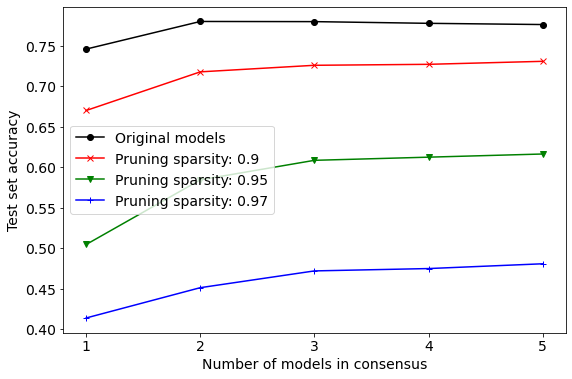

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
# print(acc)
# acc = [[0.7459, 0.78, 0.7798, 0.7777, 0.7762], [0.6701, 0.7178, 0.7259, 0.7271, 0.7308], [0.5047, 0.5845, 0.6086, 0.6125, 0.6164], [0.414, 0.4514, 0.4721, 0.475, 0.4809]]

prnt_sparsities = [0.90,0.95,0.97]
labels = [('Pruning sparsity: '+str(i)) for i in prnt_sparsities]
labels.insert(0,'Original models')
print(labels)

fig = plt.figure(1,figsize=(9,6))
plt.plot([1,2,3,4,5],acc[0],'k',label=labels[0],marker="o")
plt.plot([1,2,3,4,5],acc[1],'r-',label=labels[1],marker="x")
plt.plot([1,2,3,4,5],acc[2],'g-',label=labels[2],marker="v")
plt.plot([1,2,3,4,5],acc[3],'b-',label=labels[3],marker="+")
plt.xticks([1,2,3,4,5])

plt.xlabel('Number of models in consensus')
plt.ylabel('Test set accuracy')
plt.legend()
# plt.title('Inference accuracy vs number of models in consensus')
fig.savefig('cifar_ensemble.pdf')


### Plot Results

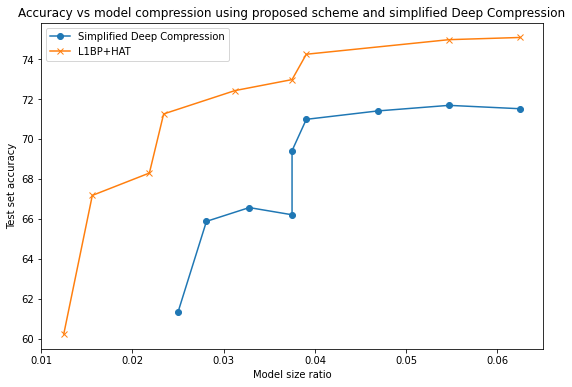

In [ ]:
import matplotlib.pyplot as plt
orig_compr = [0.25*0.25,0.25*7/32,0.25*6/32,0.25*5/32,0.2*6/32,0.15*0.25,0.15*7/32,0.15*6/32,0.1*8/32]
orig_acc   = [71.51,71.68,71.4,70.98,69.41,66.2,66.56,65.87,61.31]

mod_compr = [0.25*0.25,0.25*7/32,0.25*5/32,0.2*6/32,0.2*5/32,0.15*5/32,0.1*7/32,0.1*5/32,0.1*4/32]
mod_acc   = [75.08,74.97,74.24,72.97,72.42,71.25,68.29,67.17,60.23]

fig = plt.figure(1,figsize=(9,6))
plt.plot(orig_compr, orig_acc, label='Simplified Deep Compression',marker='o')
plt.plot(mod_compr, mod_acc, label='L1BP+HAT',marker='x')

# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.7296,0.7184,0.6972,0.6369,0.4878,0.4205], label='Original model',marker='o')
# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.734,0.7269,0.6999,0.64,0.5001,0.4502], label='Regularized model',marker='x')
plt.xlabel('Model size ratio')
plt.ylabel('Test set accuracy')
plt.legend()
plt.title('Accuracy vs model compression using proposed scheme and simplified Deep Compression')
fig.savefig('overall_comparison.pdf')